# Introduction

snpEff (https://pcingola.github.io/SnpEff/) is one of the most widely used tools for variant annotation, offering detailed impact predictions, functional classifications, codon/AA changes, and a convenient auto-generated HTML report. While the report is useful for quick inspection and result exploration, it offers limited options for the high quality data representation and programmatic data access, therefore, cannot be easily embedded into scientific pipelines and publications. Researchers often need tailored visualizations-for example, barplots with consistent color themes, heatmaps for codon or amino-acid change matrices, or comparative plots across multiple samples (e.g., tumor vs normal). 

To address this gap, we built a Python Jupyter Notebook workflow that parses snpEff statistics output file (*_stats.csv) and automatically generates customizable, publication-ready visualizations. This includes barplots, heatmaps, pie chart, line chart, all created using standard Python libraries such as matplotlib, and seaborn. The notebook gives full control over colors, layout, themes, and filtering-something the built-in snpEff HTML report cannot provide.

We are sharing this workflow so researchers can more easily integrate snpEff results into downstream analyses, generate consistent visual summaries, and adapt the plots to their own reporting or publication needs.

## 1. snpEff Stats Parser
Parse snpEff output (`sample_name_stats.csv`) and prepare a tabular files for each parameter which can be imported into R or Python enviornment to further vizualize the data.

<b>NOTE: </b> This code has been tested on the <b>SnpEff v5.1d (build 2022-04-19 15:49).</b> If you are applying it to other versions of snpEff and the code breaks please feel free to drop an email: info.bridgeomics@panelysian.com or open an github issue: https://github.com/BridgeOmics/snpEff-Representation/issues, and we will try to resolve it as soon as possible.


### 1.1 Load necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap

sns.set(style="whitegrid")

### 1.2 Sepcify input file and output directory

In [2]:
input_file = 'sample_dataset_snpeff_output/sample1_snpeff_stats.csv'
output_dir = "snpeff_results"

### 1.3 Parse input `snpEff_stats.csv` file generated by snpEff and save the individual matrix in a seperate output file

In [3]:
data_dict = {}
extractDataFlag = False
countBlankLine = 0
firstLine = True
title = ""

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

with open(input_file) as f:
    for line in f:
        if firstLine:
            firstLine = False
            continue

        if line.startswith((
            "# Change rate by chromosome", "# Variantss by type",
            "# Effects by impact", "# Effects by functional class",
            "# Count by effects", "# Count by genomic region",
            "# Ts/Tv summary", "# InDel lengths",
            "# Base changes", "# Codon change table",
            "# Amino acid change table"
        )):
            extractDataFlag = True
            countBlankLine = 0
            title = line.strip()
            data_dict[title] = {}

        if line.startswith("\n"):
            countBlankLine += 1

        if extractDataFlag and (countBlankLine == 1):
            lineArr = [x.strip() for x in line.strip().split(",")]
            if len(lineArr) > 1:
                if title in [
                    "# Variantss by type", "# Effects by impact",
                    "# Effects by functional class", "# Count by effects",
                    "# Count by genomic region", "# Ts/Tv summary"
                ]:
                    data_dict[title][lineArr[0]] = lineArr[1]
                elif title == "# Change rate by chromosome":
                    data_dict[title][lineArr[0]] = lineArr[2]
                elif title in ["# InDel lengths", "# Base changes", "# Amino acid change table"]:
                    data_dict[title][lineArr[0]] = lineArr[1:]
                elif extractDataFlag:
                    lineArr = [x.strip() for x in line.strip().split(",")]
                    if len(lineArr) > 1:
                        data_dict[title][lineArr[0]] = lineArr[1:]

for key in data_dict.keys():
    f_name = key.replace("# ", "").replace(" ", "_").replace("/", "_")

    if key in ["# Base changes", "# Codon change table", "# Amino acid change table"]:
        df = pd.DataFrame(data_dict[key])
        if not df.empty:
            df.to_csv(os.path.join(output_dir, f"{f_name}.csv"), index=False)

    elif key == "# InDel lengths":
        df = pd.DataFrame(data_dict[key])
        if not df.empty:
            df.columns = ["features", "values"]
            df.to_csv(os.path.join(output_dir, f"{f_name}.csv"), index=False)

    elif key in [
        "# Variantss by type", "# Effects by impact",
        "# Effects by functional class", "# Count by effects",
        "# Count by genomic region", "# Change rate by chromosome"
    ]:
        listOfValues = list(data_dict[key].items())[1:]
        df = pd.DataFrame(listOfValues, columns=["features", "values"])
        if not df.empty:
            df.to_csv(os.path.join(output_dir, f"{f_name}.csv"), index=False)

    elif key == "# Ts/Tv summary":
        listOfValues = list(data_dict[key].items())[:-1]
        df = pd.DataFrame(listOfValues, columns=["features", "values"])
        if not df.empty:
            df.to_csv(os.path.join(output_dir, f"{f_name}.csv"), index=False)

## 2. Plotting parsed SnpEff output

### 2.1 Sepcify colors for the plots

In [4]:
custom_pie_cols = ["#FF7F00", "#984EA3", "#4DAF4A", "#377EB8", "#E41A1C", "#D6D636"]
plot_color = "#572685"
#output_formats = ["png", "pdf"]  # which formats to save

### 2.2 This function is used to save plots when needed. Since we can display the plots directly in this notebook, we won’t use it for now.

In [5]:
def save_figure(fig, path_without_ext, formats=("png", "pdf"), dpi=300):
    for fmt in formats:
        out_file = f"{path_without_ext}.{fmt}"
        try:
            if fmt == "pdf":
                fig.savefig(out_file, bbox_inches='tight')
            else:
                fig.savefig(out_file, dpi=dpi, bbox_inches='tight')
        except Exception as e:
            print(f"Could not save {out_file}: {e}")

### 2.3 Originally, discrete colormaps have a limited number of colors. This function generates a discrete palette from any valid Matplotlib colormap, ensuring the number of colors matches the number of categories.

In [6]:
def get_discrete_cmap(n, base_cmap="tab20"):
    base = plt.get_cmap(base_cmap)
    colors = base(np.linspace(0, 1, n))
    return ListedColormap(colors)

### 2.4 Function to generate the pie chart

In [7]:
def plot_pie_chart(input_csv, x="values", y="features", title=None, save_path=None, figsize=(6, 6), xlabel=None, ylabel=None, base_cmap = 'tab20'):
    N = len(df)
    if(isinstance(base_cmap, list)):
        colors = base_cmap
    else:
        cmap = get_discrete_cmap(N, base_cmap=base_cmap)
        colors = cmap(np.arange(N))
    
    fig, ax = plt.subplots(figsize=figsize)
    wedges, texts, autotexts = ax.pie(
        df[x],
        labels=None,
        autopct="%1.1f%%",
        startangle=140,
        pctdistance=0.8,
        textprops={'color':"w"},
        colors = colors
    )
    
    plt.legend(
        wedges,
        df[y],
        title="",
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        frameon=False
    )
    
    plt.setp(autotexts, size=10, weight="bold")
    plt.title(title if title else "")
    
    ax.set_xlabel(xlabel if xlabel else "")
    ax.set_ylabel(ylabel if ylabel else "")
    ax.grid(False)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.pdf", dpi=300, bbox_inches="tight")
    
    plt.show()

### 2.5 Function to generate the barplot

In [8]:
def plot_barplot(df, x="values", y="features", title=None, save_path=None, color="#42738f", figsize=(6.5, 4), xlabel=None, ylabel=None):
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(data=df, x=x, y=y, ax=ax, color=color)
    
    ax.set_xlabel(xlabel if xlabel else "")
    ax.set_ylabel(ylabel if ylabel else "")
    ax.set_title(title if title else "")
    ax.grid(False)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.pdf", dpi=300, bbox_inches="tight")
    
    plt.show()

### 2.6 Function to generate the line plot

In [9]:
def plot_linechart(df, x="features", y="values", title=None, save_path=None, color="#42738f", figsize=(6,4), 
                   xlabel=None, ylabel=None, line_width = 1.5):
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(data=df, x=x, y=y, ax=ax, color=color, linewidth = line_width)
    ax.set_xlabel(xlabel if xlabel else "")
    ax.set_ylabel(ylabel if ylabel else "")
    ax.set_title(title if title else "")
    plt.xticks(rotation=45)
    ax.grid(False)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.pdf", dpi=300, bbox_inches="tight")
    
    plt.show()

### 2.7 Function to generate the heatmaps

In [10]:
def plot_heatmap(df, title=None, save_path=None, figsize=(6, 6), cmap="viridis", linewidths=0.5, linecolor="gray", 
                 mask_zeros=True, box_line_w = 0.5, ylabel = ""):
    M = df.copy()
    if mask_zeros:
        M = M.replace(0, np.nan)

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        M, ax=ax, cmap=cmap,
        linewidths=linewidths, linecolor=linecolor,
        cbar_kws={'label': 'count'},
        mask=M.isna()
    )
    
    # Add border around entire heatmap
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(box_line_w)
        spine.set_color("black")
    
    plt.xticks(rotation=90)
    ax.set_title(title if title else "")
    ax.set_ylabel(ylabel)
    ax.grid(False)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.pdf", dpi=300, bbox_inches="tight")
    
    plt.show()
    #return fig

## 3. Call functions to plot the parsed data 

### 3.1 Barplot representing Number of Variants per Chromosome

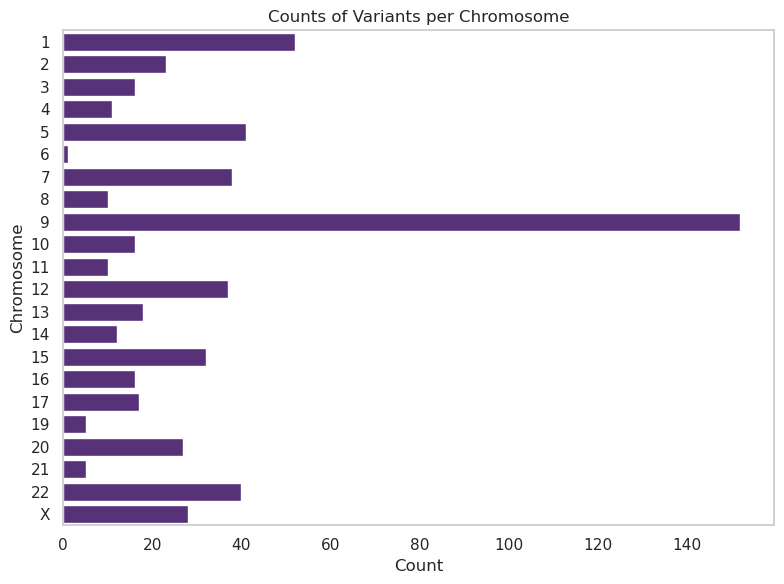

In [11]:
df = pd.read_csv(os.path.join(output_dir, 'Change_rate_by_chromosome.csv'), index_col=0, keep_default_na=False)
plot_barplot(df, color = plot_color, ylabel = 'Chromosome', xlabel = 'Count', title="Counts of Variants per Chromosome", figsize=(8,6))

### 3.2 Barplot & Piechart representing Number per Variants Types

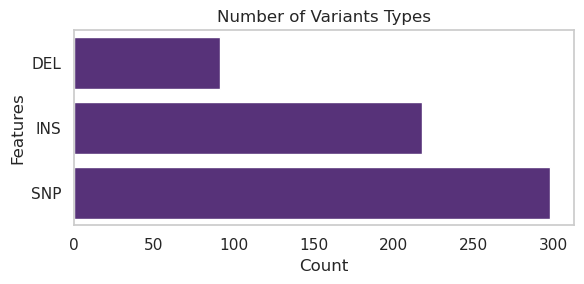

In [12]:
df = pd.read_csv(os.path.join(output_dir, 'Variantss_by_type.csv'), index_col=0, keep_default_na=False)
plot_barplot(df, color = plot_color, ylabel = 'Features', xlabel = 'Count', title="Number of Variants Types", figsize=(6,3))

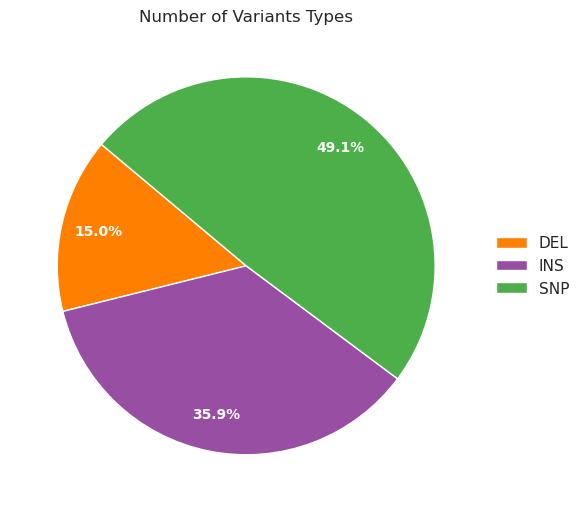

In [13]:
df = pd.read_csv(os.path.join(output_dir, 'Variantss_by_type.csv'), keep_default_na=False)
plot_pie_chart(df, xlabel="", ylabel="", base_cmap = custom_pie_cols, title="Number of Variants Types", figsize = (6,6))

### 3.3 Heatmap representating Amino Acid Changes

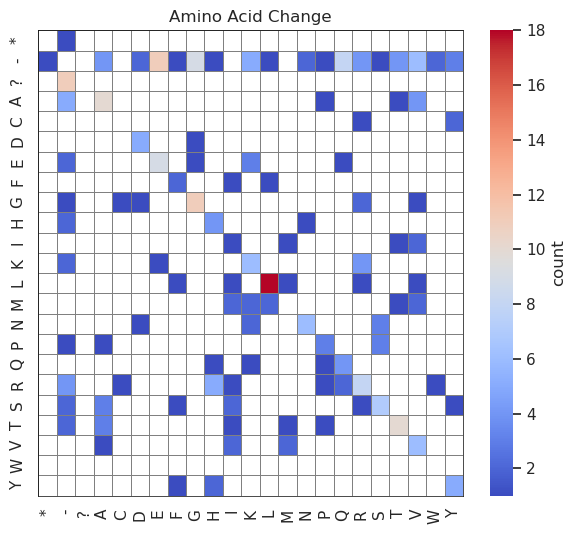

In [14]:
## Heatmap for Amino Acid Change Table
df = pd.read_csv(os.path.join(output_dir, "Amino_acid_change_table.csv"), index_col=0)
plot_heatmap(df, title = "Amino Acid Change", cmap='coolwarm', figsize=(6,5.5))

### 3.4 Heatmap representating Nucleotide Changes

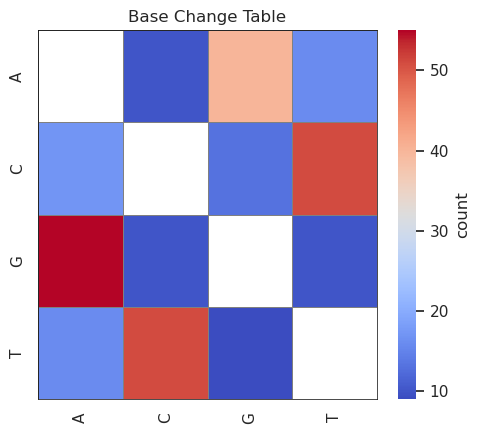

In [15]:
## Heatmap for Base Change Table
df = pd.read_csv(os.path.join(output_dir, "Base_changes.csv"), index_col=0)
plot_heatmap(df, title = "Base Change Table", cmap = 'coolwarm', figsize=(5,4.5))

### 3.5 Line plot representating the Length Distribution of InDels

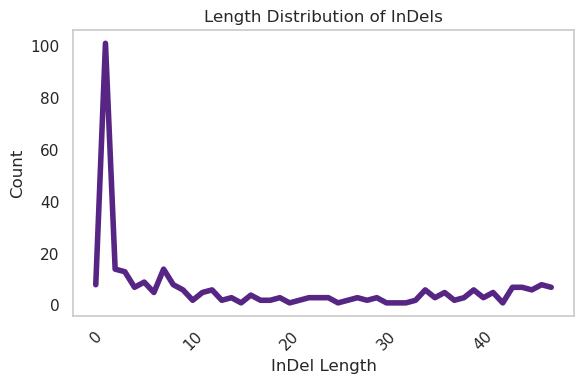

In [16]:
## Distribution of the InDels
df = pd.read_csv(os.path.join(output_dir, 'InDel_lengths.csv'), index_col=0)
plot_linechart(df, title = 'Length Distribution of InDels', color = plot_color, ylabel = 'Count', xlabel = 'InDel Length', line_width = 4)

### 3.6 Barplot representating the Number of Variant Effect

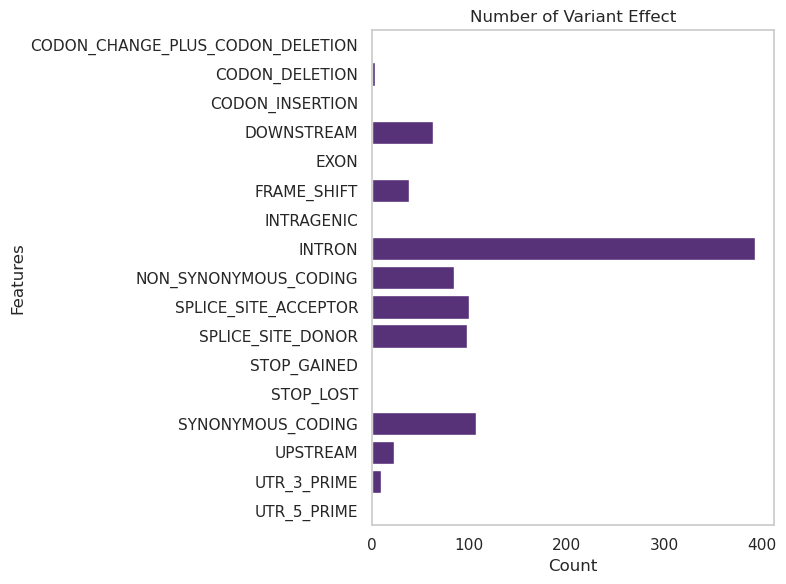

In [17]:
df = pd.read_csv(os.path.join(output_dir, 'Count_by_effects.csv'), index_col=0, keep_default_na=False)
plot_barplot(df, color = plot_color, ylabel = 'Features', xlabel = 'Count', title="Number of Variant Effect", figsize=(8,6))	

### 3.7 Barplot & Pie Chart representating the Number of Variant Effect by their Functional Class

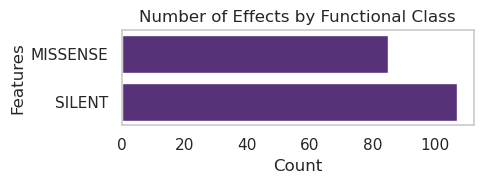

In [18]:
df = pd.read_csv(os.path.join(output_dir, 'Effects_by_functional_class.csv'), index_col=0, keep_default_na=False)
plot_barplot(df, color = plot_color, ylabel = 'Features', xlabel = 'Count', title="Number of Effects by Functional Class", figsize=(5,2))

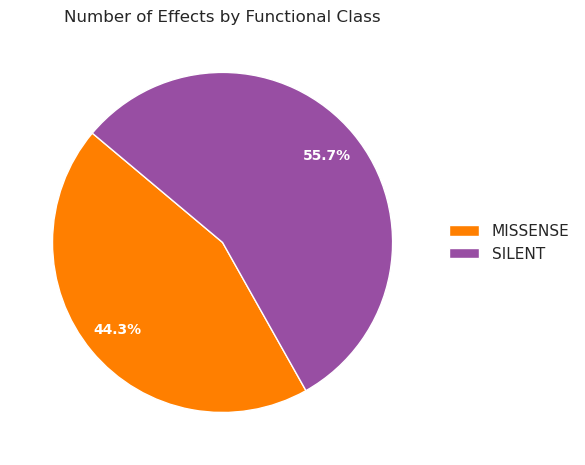

In [19]:
df = pd.read_csv(os.path.join(output_dir, 'Effects_by_functional_class.csv'), keep_default_na=False)
plot_pie_chart(df, xlabel="", ylabel="", base_cmap = custom_pie_cols, title="Number of Effects by Functional Class", figsize = (6,6))

### 3.8 Barplot & Pie Chart representating the Number of Variant Effect by their Impact

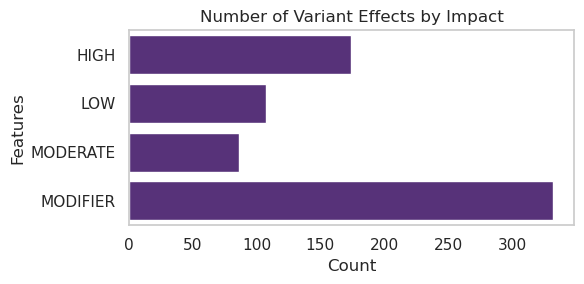

In [20]:
df = pd.read_csv(os.path.join(output_dir, 'Effects_by_impact.csv'), index_col=0, keep_default_na=False)
plot_barplot(df, color = plot_color, ylabel = 'Features', xlabel = 'Count', title="Number of Variant Effects by Impact", figsize=(6,3))

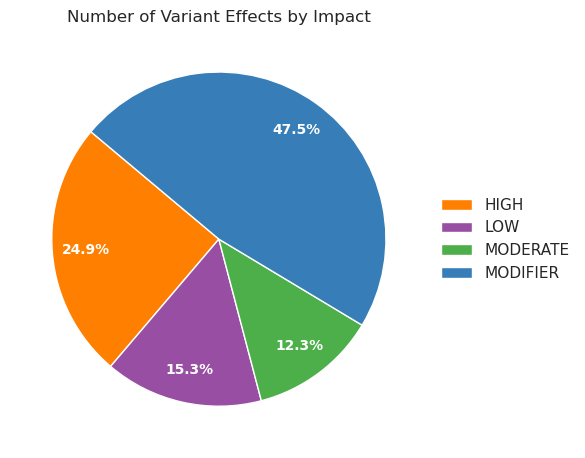

In [21]:
df = pd.read_csv(os.path.join(output_dir, 'Effects_by_impact.csv'), keep_default_na=False)
plot_pie_chart(df, xlabel="", ylabel="", base_cmap = custom_pie_cols, 
               title="Number of Variant Effects by Impact", figsize = (6,6))

### 3.9 Barplot & Pie Chart representating the Number of Variants by their Distribution in Different Genomic Regions

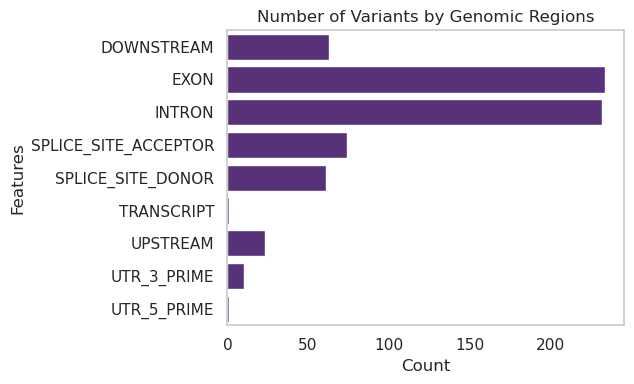

In [22]:
## Count_by_genomic_region.csv
df = pd.read_csv(os.path.join(output_dir, 'Count_by_genomic_region.csv'), index_col=0, keep_default_na=False)
plot_barplot(df, color = plot_color, ylabel = 'Features', xlabel = 'Count', title="Number of Variants by Genomic Regions")

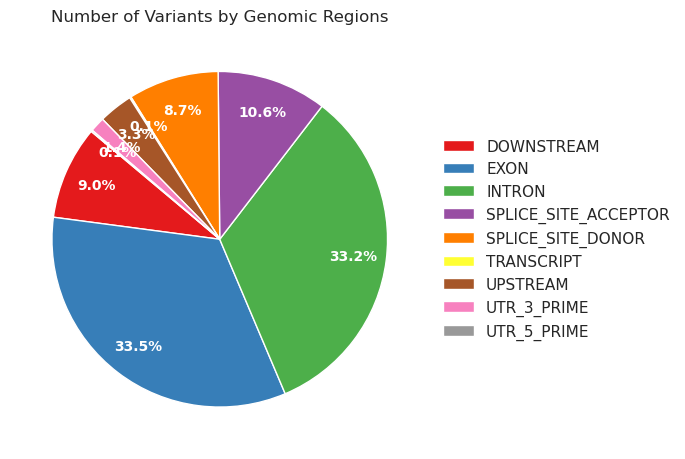

In [23]:
df = pd.read_csv(os.path.join(output_dir, 'Count_by_genomic_region.csv'), keep_default_na=False)
plot_pie_chart(df, xlabel="", ylabel="", base_cmap = "Set1", title="Number of Variants by Genomic Regions", figsize = (7,7))

### 3.10 Barplot & Pie Chart representating the Numer of Transitions & Transversions

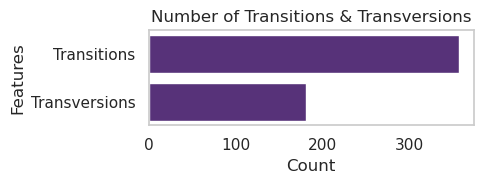

In [24]:
df = pd.read_csv(os.path.join(output_dir, 'Ts_Tv_summary.csv'), index_col=0, keep_default_na=False)
plot_barplot(df, color = plot_color, ylabel = 'Features', xlabel = 'Count', title="Number of Transitions & Transversions", figsize=(5,2))

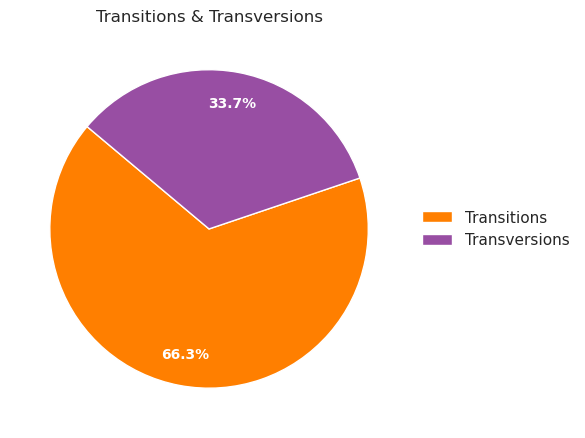

In [25]:
df = pd.read_csv(os.path.join(output_dir, 'Ts_Tv_summary.csv'), keep_default_na=False)
plot_pie_chart(df, xlabel="", ylabel="", base_cmap = custom_pie_cols, title="Transitions & Transversions", figsize = (6,6))